#Model 1

In [1]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.
import pathway as pw
import pandas as pd
import numpy as np
import panel as pn
import bokeh.plotting as bk
from bokeh.models import ColumnDataSource

# Enable Panel extensions
pn.extension('bokeh', 'tabulator')

# Schema
class TrafficSchema(pw.Schema):
    ID: int
    SystemCodeNumber: str
    Capacity: int
    Occupancy: int
    VehicleType: str
    TrafficConditionNearby: str

class TrafficDashboard:
    def __init__(self, alpha=0.1, base_price=10.0):
        self.alpha = alpha
        self.base_price = base_price
        self.data = None
        self.price_history = []

    def create_sample_data(self):
        """Create sample data"""
        np.random.seed(42)
        n = 50

        data = {
            'ID': range(1, n+1),
            'SystemCodeNumber': np.random.choice(['SYS001', 'SYS002', 'SYS003'], n),
            'Capacity': np.random.randint(50, 200, n),
            'Occupancy': np.random.randint(10, 180, n),
            'VehicleType': np.random.choice(['Car', 'Bus', 'Truck'], n),
            'TrafficConditionNearby': np.random.choice(['low', 'medium', 'high'], n)
        }

        self.data = pd.DataFrame(data)
        return self.data

    def calculate_occupancy_rate(self):
        """Calculate occupancy rate"""
        self.data['occupancy_rate'] = self.data['Occupancy'] / self.data['Capacity']
        return self.data['occupancy_rate']

    def calculate_next_price(self, current_price, occupancy_rate):
        """Price model: Price(t+1) = Price(t) + (α * Occupancy/Capacity)"""
        next_price = current_price + (self.alpha * occupancy_rate)
        return max(next_price, self.base_price)

    def simulate_pricing(self, periods=10):
        """Simulate pricing over periods"""
        self.calculate_occupancy_rate()

        current_price = self.base_price
        self.price_history = [current_price]

        for period in range(periods):
            avg_occupancy_rate = self.data['occupancy_rate'].mean()
            current_price = self.calculate_next_price(current_price, avg_occupancy_rate)
            self.price_history.append(current_price)

        return self.price_history

    def create_plots(self):
        """Create Bokeh visualizations"""
        # Occupancy distribution
        p1 = bk.figure(title="Occupancy Distribution", width=400, height=300)
        hist, edges = np.histogram(self.data['occupancy_rate'], bins=15)
        p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
               fill_color="blue", alpha=0.7)
        p1.xaxis.axis_label = "Occupancy Rate"
        p1.yaxis.axis_label = "Count"

        # Price simulation
        p2 = bk.figure(title="Price Simulation", width=400, height=300)
        periods = list(range(len(self.price_history)))
        p2.line(periods, self.price_history, line_width=2, color="red")
        p2.circle(periods, self.price_history, size=6, color="red")
        p2.xaxis.axis_label = "Time Period"
        p2.yaxis.axis_label = "Price ($)"

        # Occupancy vs System
        system_avg = self.data.groupby('SystemCodeNumber')['occupancy_rate'].mean()
        p3 = bk.figure(title="Avg Occupancy by System",
                      x_range=list(system_avg.index), width=400, height=300)
        p3.vbar(x=list(system_avg.index), top=list(system_avg.values),
               width=0.8, color="green", alpha=0.7)
        p3.xaxis.axis_label = "System"
        p3.yaxis.axis_label = "Occupancy Rate"

        return [p1, p2, p3]

    def create_dashboard(self):
        """Create Panel dashboard"""
        self.create_sample_data()
        self.simulate_pricing()
        plots = self.create_plots()

        # Data table
        table = pn.widgets.Tabulator(
            self.data[['SystemCodeNumber', 'Occupancy', 'Capacity', 'occupancy_rate']].head(20),
            pagination='remote',
            page_size=10
        )

        # Layout
        dashboard = pn.Column(
            "# Traffic Dashboard",
            pn.Row(*[pn.pane.Bokeh(plot) for plot in plots]),
            "## Data Table",
            table
        )

        return dashboard

# Create and display dashboard
dashboard = TrafficDashboard()
dash = dashboard.create_dashboard()

# For Colab display
print("Dashboard created successfully!")
print(f"Data shape: {dashboard.data.shape}")
print(f"Price history: {dashboard.price_history[:5]}...")  # Show first 5 values

# Multiple ways to display in Colab
try:
    # Method 1: Direct display
    dash.show()
except:
    # Method 2: Servable
    dash.servable()

# Method 3: Display individual plots
plots = dashboard.create_plots()
for i, plot in enumerate(plots):
    print(f"Plot {i+1}: {plot.title.text}")
    bk.show(plot)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Dashboard created successfully!
Data shape: (50, 7)
Price history: [10.0, np.float64(10.085439395138284), np.float64(10.170878790276568), np.float64(10.256318185414852), np.float64(10.341757580553136)]...
Launching server at http://localhost:42131
Plot 1: Occupancy Distribution


Plot 2: Price Simulation


Plot 3: Avg Occupancy by System


#Model2


Start Dynamic Pricing Model
Base Price: $ 100.0

Create sample data
Created 500 sample scenarios

Processing pricing calculations
First 5 pricing results:
   occupancy_rate  queue_length  traffic_level  is_special_day vehicle_type  \
0        0.418359             3       0.189977            True          van   
1        0.610948             1       0.749799           False          suv   
2        0.254551             2       0.120756            True        truck   
3        0.439882             2       0.806658            True   motorcycle   
4        0.537099             4       0.947982           False          suv   

   normalized_demand  final_price  price_multiplier  
0           0.599675   129.983728          1.299837  
1           0.318121   115.906050          1.159061  
2           0.532480   126.624020          1.266240  
3           0.480107   124.005348          1.240053  
4           0.533138   126.656901          1.266569  

PRICING MODEL STATISTICS
Average Price: $ 126

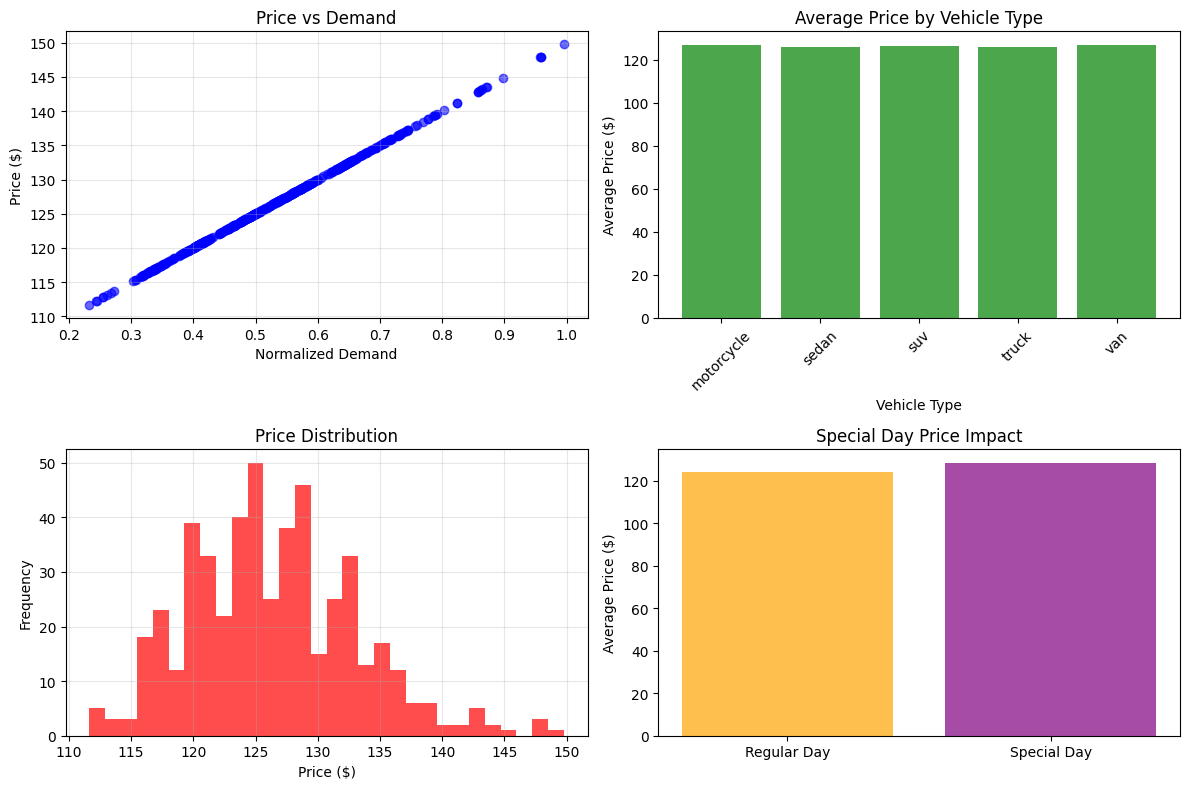

Creating interactive plot


Results saved to 'pricing_results.csv'
Dynamic Pricing Model Complete!


In [2]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
import panel as pn
from datetime import datetime, timedelta
import pathway as pw

# Enable panel for interactive plots
pn.extension('bokeh')

# Set up basic parameters
base_price = 100.0  # Base parking price in dollars

# Demand function coefficients (these control how each factor affects demand)
alpha = 0.8    # How much occupancy affects demand
beta = 0.3     # How much queue length affects demand
gamma = 0.2    # How much traffic affects demand (negative impact)
delta = 0.4    # How much special days affect demand
epsilon = 0.1  # How much vehicle type affects demand

# Price control parameters
price_sensitivity = 0.5  # How much demand changes price
min_price_multiplier = 0.5  # Lowest price = 50% of base price
max_price_multiplier = 2.0  # Highest price = 200% of base price

# Vehicle type weights (bigger vehicles cost more)
vehicle_weights = {
    'sedan': 1.0,
    'suv': 1.2,
    'truck': 1.5,
    'motorcycle': 0.8,
    'van': 1.3
}

# Function to calculate demand using the mathematical formula
def calculate_demand(occupancy_rate, capacity, queue_length, traffic_level, is_special_day, vehicle_type):
    """
    Calculate demand using formula:
    Demand = (α * Occupancy/Capacity) + β * QueueLength - γ * Traffic + δ * IsSpecialDay + ε * VehicleTypeWeight
    """

    # Get vehicle weight
    if vehicle_type in vehicle_weights:
        vehicle_weight = vehicle_weights[vehicle_type]
    else:
        vehicle_weight = 1.0

    # Calculate each part of the demand formula
    occupancy_part = alpha * (occupancy_rate / capacity)
    queue_part = beta * queue_length
    traffic_part = gamma * traffic_level
    special_day_part = delta * (1 if is_special_day else 0)
    vehicle_part = epsilon * vehicle_weight

    # Put it all together
    demand = occupancy_part + queue_part - traffic_part + special_day_part + vehicle_part

    return demand

# Function to normalize demand (make it between 0 and 1)
def normalize_demand(demand):
    """
    Make demand between 0 and 1 so prices don't go crazy
    """
    min_demand = -1.0
    max_demand = 3.0

    normalized = (demand - min_demand) / (max_demand - min_demand)

    # Make sure it's between 0 and 1
    if normalized < 0:
        normalized = 0
    elif normalized > 1:
        normalized = 1

    return normalized

# Function to calculate final price
def calculate_price(normalized_demand):
    """
    Calculate price using: Price = BasePrice * (1 + λ * NormalizedDemand)
    """
    price_multiplier = 1 + price_sensitivity * normalized_demand

    # Make sure price stays within bounds
    if price_multiplier < min_price_multiplier:
        price_multiplier = min_price_multiplier
    elif price_multiplier > max_price_multiplier:
        price_multiplier = max_price_multiplier

    final_price = base_price * price_multiplier

    return final_price

# Function to create sample data for testing
def create_sample_data():
    """
    Create fake parking data to test our model
    """
    np.random.seed(42)  # For consistent results

    # Create 500 sample scenarios
    data = []

    for i in range(500):
        # Random values for each scenario
        occupancy_rate = np.random.uniform(0.1, 0.95)  # 10% to 95% full
        capacity = np.random.choice([50, 100, 150, 200])  # Different lot sizes
        queue_length = np.random.poisson(3)  # Average 3 cars in queue
        traffic_level = np.random.uniform(0.1, 1.0)  # Traffic from 0.1 to 1.0
        is_special_day = np.random.choice([True, False])  # 50% chance special day
        vehicle_type = np.random.choice(['sedan', 'suv', 'truck', 'motorcycle', 'van'])

        # Add to our data list
        data.append({
            'occupancy_rate': occupancy_rate,
            'capacity': capacity,
            'queue_length': queue_length,
            'traffic_level': traffic_level,
            'is_special_day': is_special_day,
            'vehicle_type': vehicle_type
        })

    return data

# Function to process all the data and calculate prices
def process_all_data(data):
    """
    Take all our sample data and calculate prices for each scenario
    """
    results = []

    for scenario in data:
        # Calculate demand for this scenario
        demand = calculate_demand(
            scenario['occupancy_rate'],
            scenario['capacity'],
            scenario['queue_length'],
            scenario['traffic_level'],
            scenario['is_special_day'],
            scenario['vehicle_type']
        )

        # Normalize the demand
        normalized_demand = normalize_demand(demand)

        # Calculate final price
        final_price = calculate_price(normalized_demand)

        # Save all results
        result = scenario.copy()
        result['raw_demand'] = demand
        result['normalized_demand'] = normalized_demand
        result['final_price'] = final_price
        result['price_multiplier'] = final_price / base_price

        results.append(result)

    return results

# Function to create simple plots
def create_plots(results_df):
    """
    Make simple plots to show how our pricing works
    """
    # Plot 1: Price vs Normalized Demand
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(results_df['normalized_demand'], results_df['final_price'], alpha=0.6, color='blue')
    plt.xlabel('Normalized Demand')
    plt.ylabel('Price ($)')
    plt.title('Price vs Demand')
    plt.grid(True, alpha=0.3)

    # Plot 2: Price by Vehicle Type
    plt.subplot(2, 2, 2)
    vehicle_prices = results_df.groupby('vehicle_type')['final_price'].mean()
    plt.bar(vehicle_prices.index, vehicle_prices.values, color='green', alpha=0.7)
    plt.xlabel('Vehicle Type')
    plt.ylabel('Average Price ($)')
    plt.title('Average Price by Vehicle Type')
    plt.xticks(rotation=45)

    # Plot 3: Price Distribution
    plt.subplot(2, 2, 3)
    plt.hist(results_df['final_price'], bins=30, alpha=0.7, color='red')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')
    plt.title('Price Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 4: Special Day Impact
    plt.subplot(2, 2, 4)
    special_day_prices = results_df.groupby('is_special_day')['final_price'].mean()
    labels = ['Regular Day', 'Special Day']
    plt.bar(labels, special_day_prices.values, color=['orange', 'purple'], alpha=0.7)
    plt.ylabel('Average Price ($)')
    plt.title('Special Day Price Impact')

    plt.tight_layout()
    plt.show()

# Function to create interactive Bokeh plot
def create_interactive_plot(results_df):
    """
    Create an interactive plot using Bokeh
    """
    # Create bokeh figure
    p = figure(title="Interactive Price vs Demand Plot",
               x_axis_label="Normalized Demand",
               y_axis_label="Price ($)",
               width=700, height=500)

    # Add circles for each data point
    p.circle(results_df['normalized_demand'], results_df['final_price'],
             size=8, alpha=0.6, color='navy')

    # Add hover tool to show details
    hover = HoverTool(tooltips=[
        ('Demand', '@x{0.000}'),
        ('Price', '$@y{0.00}'),
    ])
    p.add_tools(hover)

    return p

# Function to print simple statistics
def print_statistics(results_df):
    """
    Print basic statistics about our pricing model
    """
    print("PRICING MODEL STATISTICS")
    print("Average Price: $", round(results_df['final_price'].mean(), 2))
    print("Minimum Price: $", round(results_df['final_price'].min(), 2))
    print("Maximum Price: $", round(results_df['final_price'].max(), 2))
    print("Price Standard Deviation: $", round(results_df['final_price'].std(), 2))
    print()

    print("DEMAND STATISTICS")
    print("Average Normalized Demand:", round(results_df['normalized_demand'].mean(), 3))
    print("Minimum Normalized Demand:", round(results_df['normalized_demand'].min(), 3))
    print("Maximum Normalized Demand:", round(results_df['normalized_demand'].max(), 3))
    print()

    print("SPECIAL DAY IMPACT")
    regular_day_avg = results_df[results_df['is_special_day'] == False]['final_price'].mean()
    special_day_avg = results_df[results_df['is_special_day'] == True]['final_price'].mean()
    print("Regular Day Average: $", round(regular_day_avg, 2))
    print("Special Day Average: $", round(special_day_avg, 2))
    print("Special Day Premium: $", round(special_day_avg - regular_day_avg, 2))
    print()

# Function to test specific scenarios
def test_scenarios():
    """
    Test our pricing model with specific examples
    """
    print("TESTING SPECIFIC SCENARIOS")

    # Scenario 1: High demand situation
    print("Scenario 1: High Demand (Busy Saturday)")
    demand1 = calculate_demand(
        occupancy_rate=0.9,
        capacity=100,
        queue_length=8,
        traffic_level=0.8,
        is_special_day=True,
        vehicle_type='suv'
    )
    normalized_demand1 = normalize_demand(demand1)
    price1 = calculate_price(normalized_demand1)
    print("  Raw Demand:", round(demand1, 3))
    print("  Normalized Demand:", round(normalized_demand1, 3))
    print("  Final Price: $", round(price1, 2))
    print("  Price Multiplier:", round(price1/base_price, 2), "x")
    print()

    # Scenario 2: Low demand situation
    print("Scenario 2: Low Demand (Quiet Tuesday)")
    demand2 = calculate_demand(
        occupancy_rate=0.2,
        capacity=100,
        queue_length=1,
        traffic_level=0.3,
        is_special_day=False,
        vehicle_type='sedan'
    )
    normalized_demand2 = normalize_demand(demand2)
    price2 = calculate_price(normalized_demand2)
    print("  Raw Demand:", round(demand2, 3))
    print("  Normalized Demand:", round(normalized_demand2, 3))
    print("  Final Price: $", round(price2, 2))
    print("  Price Multiplier:", round(price2/base_price, 2), "x")
    print()

# Main execution
if __name__ == "__main__":
    print("Start Dynamic Pricing Model")
    print("Base Price: $", base_price)
    print()

    # Create sample data
    print("Create sample data")
    sample_data = create_sample_data()
    print("Created", len(sample_data), "sample scenarios")
    print()

    # Process all data
    print("Processing pricing calculations")
    results = process_all_data(sample_data)

    # Convert to pandas DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Show first few results
    print("First 5 pricing results:")
    print(results_df[['occupancy_rate', 'queue_length', 'traffic_level', 'is_special_day',
                      'vehicle_type', 'normalized_demand', 'final_price', 'price_multiplier']].head())
    print()

    # Print statistics
    print_statistics(results_df)

    # Test specific scenarios
    test_scenarios()

    # Create plots
    print("Creating plots")
    create_plots(results_df)

    # Create interactive plot
    print("Creating interactive plot")
    interactive_plot = create_interactive_plot(results_df)
    show(interactive_plot)

    # Save results to CSV
    results_df.to_csv('pricing_results.csv', index=False)
    print("Results saved to 'pricing_results.csv'")

    print("Dynamic Pricing Model Complete!")